# Stylometric Analysis
## An Initial Stab

In [ ]:
#=================================================================
# Load Libraries
#=================================================================

import pandas as pd
import spacy
from scipy import stats as s

# This language model will be used for tokenizing and pos tagging
nlp = spacy.load("en_core_web_sm")

In [159]:
#=================================================================
# Import and Format Data
#=================================================================

df = pd.read_excel ("/Users/kyleeschen/Downloads/asap-aes/training_set_rel3.xlsx")

# Drop all unnecessary columns to simplify later clustering.
df = df[["essay", "rater1_domain1"]]

In [161]:
#=================================================================
# Transform Utilities
#=================================================================

def mapOverRows(df, f, col):
    return df.apply(lambda row : f(row[col]), axis = 1) 

def genTransform(f, new_colname, from_colname):
    '''
    Returns a function that will add a
    column to a dataframe by applying function
    f over every row in column from_colname.
    '''
    def transform(df):
        df[new_colname] = mapOverRows(df, f, from_colname)
        return df
    return transform

def applyTransforms(df, transforms):
    '''
    Takes a list of dataframe transformations
    and appends them one at a time to the input
    dataframe, which it then returns.
    '''
    for t in transforms:
        df = t(df)
    return df

#=================================================================
# Counts
#=================================================================

def wordCount(essay):
    return len(essay.split())
               
def uniqueWordCount(essay):
    return len(set(essay.split()))
               
#=================================================================
# Lexical Richness
#=================================================================
               
def shannonEntropy(essay):
    splitText = pd.Series(essay.split())
    return s.entropy(splitText.value_counts())

#=================================================================
# Tokens
#=================================================================   
               
def essayToTokens(essay):
    "Generates a column of Spacy tokens."
    return nlp(essay)
            
def partOfSpeech(row):
    '''
    For each row, assigns a POS for
    each word in the text.
    '''
    return [token.pos_ for token in row]

def posEntropy(pos):
    counts = pd.Series(pos).value_counts()
    return s.entropy(counts)

def posCounts(pos):
    return pd.Series(pos).value_counts()

def addPosCountCols():
    def transform(df):
        counts = mapOverRows(df, posCounts, "partOfSpeech") 
        counts_df = pd.DataFrame(counts).fillna(0)
        return pd.concat([df, counts_df], axis= 1)
    return transform

#=================================================================
# Run Transformation Pipeline
#=================================================================   

temp = applyTransforms(df, [genTransform(wordCount,"wordCount", "essay"),
                            genTransform(uniqueWordCount, "uniqueWordCount", "essay"),
                            genTransform(shannonEntropy, "shannonEntropy","essay"),
                            genTransform(essayToTokens,"token", "essay"),
                            genTransform(partOfSpeech, "partOfSpeech", "token"),
                            genTransform(posEntropy, "posEntropy","partOfSpeech"),
                            addPosCountCols()])
temp.head()

,essay,rater1_domain1,wordCount,uniqueWordCount,shannonEntropy,token,partOfSpeech,posEntropy,ADJ,ADP,...,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X
0,"Dear local newspaper, I think effects computer...",4.0,338,184,4.869895,"(Dear, local, newspaper, ,, I, think, effects,...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN...",2.428779,17.0,45.0,...,0.0,16.0,36.0,5.0,38.0,13.0,0.0,6.0,51.0,0.0
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,419,216,5.036057,"(Dear, @CAPS1, @CAPS2, ,, I, believe, that, us...","[ADJ, PUNCT, INTJ, PUNCT, PRON, VERB, SCONJ, V...",2.324762,25.0,47.0,...,5.0,10.0,34.0,3.0,34.0,12.0,0.0,0.0,85.0,0.0
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,279,167,4.807382,"(Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, m...","[ADJ, PUNCT, PUNCT, PUNCT, VERB, ADJ, CCONJ, A...",2.334019,19.0,33.0,...,3.0,10.0,20.0,1.0,25.0,6.0,0.0,0.0,41.0,0.0
3,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,524,275,5.173716,"(Dear, Local, Newspaper, ,, @CAPS1, I, have, f...","[PROPN, PROPN, PROPN, PUNCT, PUNCT, PRON, AUX,...",2.359563,40.0,56.0,...,0.0,23.0,20.0,30.0,51.0,13.0,0.0,0.0,81.0,1.0
4,"Dear @LOCATION1, I know having computers has a...",4.0,465,226,4.995823,"(Dear, @LOCATION1, ,, I, know, having, compute...","[ADJ, PROPN, PUNCT, PRON, VERB, VERB, NOUN, AU...",2.358943,29.0,37.0,...,3.0,20.0,30.0,2.0,43.0,14.0,0.0,1.0,83.0,0.0


In [224]:
#=================================================================
# PCA
#================================================================= 

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

data = temp.drop(columns = ["essay", "token", 'X', "partOfSpeech", "rater1_domain1"])
data = data.fillna(0)
data = normalize(data)

def applyPCA(df, n):
    pca = PCA(n_components=n)
    pca.fit(data)
    print("Explained Variance: " + str(pca.explained_variance_ratio_))
    return pca.transform(data)

dataPCA = applyPCA(data, 2)

Explained Variance: [0.43176687 0.16986013]


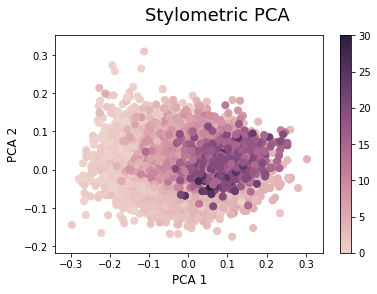

In [231]:
#=================================================================
# Plotting
#================================================================= 

import seaborn as sns
import matplotlib.pyplot as plt

def plotPCA(dataPCA):
    '''
    Credit to 
    https://stackoverflow.com/questions/39735147/how-to-color-matplotlib-scatterplot-using-a-continuous-value-seaborn-color
    for cubhelix colorscheme suggestion.
    '''
    
    cmap = sns.cubehelix_palette(as_cmap=True)

    fig, ax = plt.subplots()
    points = ax.scatter(dataPCA[:, 0], 
                        dataPCA[:, 1], 
                        c = temp["rater1_domain1"], 
                        s = 50,
                        cmap=cmap)
    fig.colorbar(points)
    fig.suptitle("Stylometric PCA", fontsize = 18)
    ax.set_xlabel('PCA 1', fontsize=12)
    ax.set_ylabel('PCA 2', fontsize=12)

plotPCA(dataPCA)